# Car Detection

In [1]:
# %pip install geoai-py

In [2]:
# import libraries
import geoai
import rasterio.plot
import rasterio as rio
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# high resolution image from OpenArialMap
raster_url = "https://oin-hotosm-temp.s3.us-east-1.amazonaws.com/67d5cf7bc8ccd45a00aa75a8/0/67d5cf7bc8ccd45a00aa75a9.tif"

In [5]:
# download the image
output_path = "oam_image.tif"
raster_path = geoai.download_file(raster_url, output_path)

oam_image.tif: 100%|██████████| 9.30M/9.30M [00:05<00:00, 1.79MB/s]


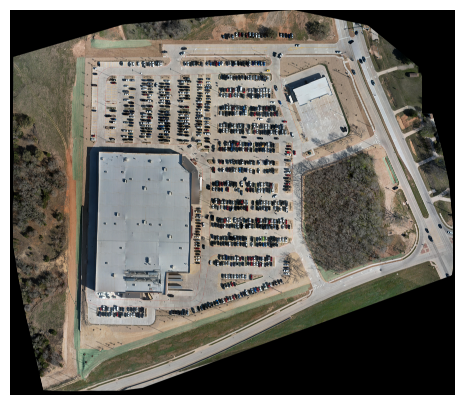

In [6]:
geoai.view_image(raster_path)

## Image Pre-Processing

In [7]:
# OAM images have a 'YCbCr JPEG' compression, which is not supported by geoai
with rio.open(raster_path) as src:
    data = src.read()
    profile = src.profile
profile

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 8166, 'height': 7073, 'count': 3, 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 14N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-99],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32614"]]'), 'transform': Affine(0.05827917922077759, 0.0, 618588.7292563973,
       0.0, -0.05827704522899349, 3624408.9201627388), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'YCbCr JPEG', 'interleave': 'pixel', 'photometric': 'ycbcr'}

In [8]:
# update the profile to 'deflate' compression
profile.update({'compress': 'deflate'})
profile.pop('photometric')
profile

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 8166, 'height': 7073, 'count': 3, 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 14N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-99],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32614"]]'), 'transform': Affine(0.05827917922077759, 0.0, 618588.7292563973,
       0.0, -0.05827704522899349, 3624408.9201627388), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'deflate', 'interleave': 'pixel'}

In [9]:
# write the updated image with the new profile
output_path = 'oam_image_updated.tif'
with rio.open(output_path, 'w', **profile) as dst:
    dst.write(data)

In [10]:
with rio.open(output_path) as src:
    print(src.profile)

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 8166, 'height': 7073, 'count': 3, 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 14N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-99],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32614"]]'), 'transform': Affine(0.05827917922077759, 0.0, 618588.7292563973,
       0.0, -0.05827704522899349, 3624408.9201627388), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'deflate', 'interleave': 'pixel'}


In [11]:
# view the updated image
geoai.view_raster(output_path)

In [12]:
# initialize the car detector
detector = geoai.CarDetector()

Model path not specified, downloading from Hugging Face...
Model downloaded to: C:\Users\PC MSI\.cache\huggingface\hub\models--giswqs--geoai\snapshots\6f9b0b4da17cc57e14e543b6e8836a83a3145c38\car_detection_usa.pth
Model loaded successfully


In [13]:
# extract cars masks
mask_path = detector.generate_masks(
    raster_path=output_path,
    output_path="cars_masks.tif",
    confidence_threshold=0.3,
    mask_threshold=0.5,
    overlap=0.25,
    chip_size=(400, 400),
)

Dataset initialized with 24 rows and 28 columns of chips
Image dimensions: 8166 x 7073 pixels
Chip size: 400 x 400 pixels
Overlap: 25.0% (stride_x=300, stride_y=300)
CRS: EPSG:32614
Processing raster with 168 batches


100%|██████████| 168/168 [01:29<00:00,  1.89it/s]


Masks with confidence values saved to cars_masks.tif


In [14]:
# Convert the image masks to polygons and save the output GeoJSON file
gdf = detector.vectorize_masks(
    masks_path="cars_masks.tif",
    output_path="cars.geojson",
 )

Processing masks from: cars_masks.tif
Found 850 connected components


Processing components: 100%|██████████| 850/850 [02:08<00:00,  6.60it/s]


Saved 842 objects with confidence to cars.geojson


In [15]:
# create an interactive map based on the confidence score
geoai.view_vector_interactive(gdf, column="confidence", tiles=raster_url)

In [16]:
# add geometric properties
gdf_prop = geoai.add_geometric_properties(gdf)

In [17]:
# filter cars by area and length
gdf_filter = gdf_prop[(gdf_prop["area_m2"] < 60) & (gdf_prop["minor_length_m"] > 1) & (gdf_prop["minor_length_m"] < 8)]

In [18]:
gdf_filter.head(2)

,geometry,confidence,class,pixels,area_m2,length_m,perimeter_m,area_bbox_m2,area_convex_m2,area_filled_m2,major_length_m,minor_length_m,eccentricity,orientation,elongation,extent,solidity,complexity
0,"POLYGON ((618958.5 3624382, 618959.5 3624387.2...",0.995788,1,3276.5,12.96875,15.542901,15.542901,19.40625,12.96875,12.96875,5.75,3.392505,0.807403,90.0,1.694913,0.668277,1.0,1.217526
1,"POLYGON ((618844.562 3624385, 618846.562 36243...",0.996078,1,2611.0,9.50000,13.500000,13.500000,9.50000,9.50000,9.50000,4.75,2.000000,0.907036,90.0,2.375000,1.000000,1.0,1.235569


In [19]:
# interactive map of filtered cars
geoai.view_vector_interactive(gdf_filter, column="confidence", tiles=raster_url)

In [21]:
# split map with filtered cars
geoai.create_split_map(
    gdf_filter,
    raster_url,
    basemap=raster_url,
    left_args={'style':{'color':'green'}, 'fillOpacity':0},
)

Map(center=[20, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…